In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [26]:
import pandas as pd

# Load the data
file_path = 'CPI UK.csv'
df = pd.read_csv(file_path, index_col=0, header=None)

# Map month abbreviations to numbers
month_map = {
    'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04',
    'MAY': '05', 'JUN': '06', 'JUL': '07', 'AUG': '08',
    'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'
}

# Convert index to 'yyyymm' format as strings
def to_yyyymm(idx):
    try:
        year, month = idx.split()
        return f"{year}{month_map[month.upper()]}"
    except Exception:
        return idx  # Leave as is if not in expected format

df.index = df.index.map(to_yyyymm)

# Reset index to access it as a column
df.reset_index(inplace=True)
df.columns = ['date', 'Index Price']


# Drop first row because it is just information of data description

df = df[1:]

# Convert 'date' to 'yyyy-mm-dd' format (use '01' as default day)
df['date'] = pd.to_datetime(df['date'], format='%Y%m').dt.strftime('%Y-%m-%d')

# Calculate 3-month rolling average on 'Index Price'
df['Index Price'] = df['Index Price'].rolling(window=3).mean()

# Filter only rows where month is in ['03', '06', '09', '12']
df_sliced = df[df['date'].str[5:7].isin(['03', '06', '09', '12'])].copy()
df_cpi_quarterly = df_sliced.copy()
# Compute annualized inflation rate
df_cpi_quarterly['Annual Inflation Rate'] = 400 * np.log(
    df_cpi_quarterly['Index Price'] / df_cpi_quarterly['Index Price'].shift(1)
)



# Load the data
df_gdp = pd.read_csv('GDP Quarterly.csv')
df_interest_quarterly = pd.read_csv('Interest Rate Quarterly.csv')
df_unemp_quarterly = pd.read_csv('Unemployment rate Quarterly.csv')

df_gdp = df_gdp.rename(columns={df_gdp.columns[0]: 'DATE'})
df_interest_quarterly  = df_interest_quarterly.rename(columns={df_interest_quarterly.columns[0]: 'DATE'})
df_interest_quarterly.rename(columns={'Interest Rate': 'Interest Rate Quarterly'}, inplace=True)
df_unemp_quarterly = df_unemp_quarterly.rename(columns={df_unemp_quarterly.columns[0]: 'DATE'})
df_unemp_quarterly.rename(columns={'Unemployment_rate': 'Unemployment Rate Quarterly'}, inplace=True)
df_cpi_quarterly = df_cpi_quarterly.rename(columns={df_cpi_quarterly.columns[0]: 'DATE'})  # Rename index column to 'date'


# Convert 'Quarterly GDP' column to numeric
df_gdp['Quarterly GDP'] = pd.to_numeric(df_gdp['Quarterly GDP'], errors='coerce')

# Calculate the log quarterly change for GDP
df_gdp['Quarterly GDP Change'] = np.log(df_gdp['Quarterly GDP']).diff() * 100


df_gdp['DATE'] = pd.to_datetime(df_gdp['DATE'], format='%Y%m')
df_gdp['DATE'] = df_gdp['DATE'].apply(lambda x: x + pd.offsets.MonthEnd(0) if x.day == 1 else x)
df_gdp['DATE'] = df_gdp['DATE'].dt.strftime('%Y-%m-%d')

df_interest_quarterly['DATE'] = pd.to_datetime(df_interest_quarterly['DATE'], format='%Y%m')
df_interest_quarterly['DATE'] = df_interest_quarterly['DATE'].apply(lambda x: x + pd.offsets.MonthEnd(0) if x.day == 1 else x)
df_interest_quarterly['DATE'] = df_interest_quarterly['DATE'].dt.strftime('%Y-%m-%d')

df_unemp_quarterly['DATE'] = pd.to_datetime(df_unemp_quarterly['DATE'], format='%Y%m')
df_unemp_quarterly['DATE'] = df_unemp_quarterly['DATE'].apply(lambda x: x + pd.offsets.MonthEnd(0) if x.day == 1 else x)
df_unemp_quarterly['DATE'] = df_unemp_quarterly['DATE'].dt.strftime('%Y-%m-%d')



# Convert 'DATE' to datetime format if not already
df_cpi_quarterly['DATE'] = pd.to_datetime(df_cpi_quarterly['DATE'], format='%Y-%m-%d')

df_cpi_quarterly['DATE'] = df_cpi_quarterly['DATE'].apply(lambda x: x + pd.offsets.MonthEnd(0) if x.day == 1 else x)



# Filter between 1988-03-01 and 2024-12-31
start_date = '1988-03-01'
end_date = '2024-12-31'

df_gdp = df_gdp[(df_gdp['DATE'] >= start_date) & (df_gdp['DATE'] <= end_date)]
df_interest_quarterly = df_interest_quarterly[(df_interest_quarterly['DATE'] >= start_date) & (df_interest_quarterly['DATE'] <= end_date)]
df_unemp_quarterly = df_unemp_quarterly[(df_unemp_quarterly['DATE'] >= start_date) & (df_unemp_quarterly['DATE'] <= end_date)]
df_cpi_quarterly = df_cpi_quarterly[(df_cpi_quarterly['DATE'] >= start_date) & (df_cpi_quarterly['DATE'] <= end_date)]


for df in [df_gdp, df_interest_quarterly, df_unemp_quarterly, df_cpi_quarterly]:
    df['DATE'] = pd.to_datetime(df['DATE'])  # Ensure datetime format
    df.set_index('DATE', inplace=True)       # Set as index



df_merged = pd.concat([
    df_cpi_quarterly['Annual Inflation Rate'],
    df_gdp['Quarterly GDP Change'],
    df_interest_quarterly['Interest Rate Quarterly'],
    df_unemp_quarterly['Unemployment Rate Quarterly']
], axis=1, join='inner')



# Rename columns for clarity
df_merged.columns = ['Annual Inflation Rate', 'Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']

# Drop rows with missing values
df_merged.dropna(inplace=True)

# Display the merged DataFrame
print("Merged DataFrame:")
print(df_merged.head())



Merged DataFrame:
            Annual Inflation Rate  Quarterly GDP Change  \
DATE                                                      
1988-06-30               7.614098              2.480186   
1988-09-30               3.219333              3.007100   
1988-12-31               4.516820              2.917238   
1989-03-31               4.205032              2.489297   
1989-06-30               8.791563              1.760053   

            Interest Rate Quarterly  Unemployment Rate Quarterly  
DATE                                                              
1988-06-30                     8.88                          8.7  
1988-09-30                    11.88                          8.4  
1988-12-31                    12.88                          8.0  
1989-03-31                    12.88                          7.6  
1989-06-30                    13.75                          7.2  


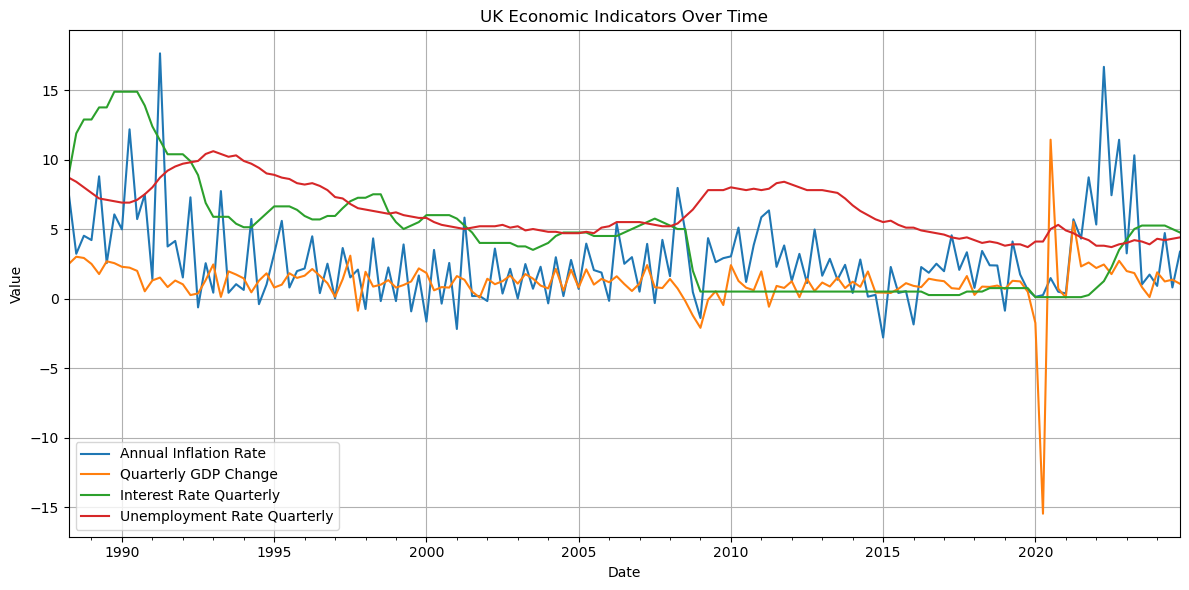

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df_merged.columns = [
    'Annual Inflation Rate',
    'Quarterly GDP Change',
    'Interest Rate Quarterly',
    'Unemployment Rate Quarterly'
]

# Plotting
df_merged.plot(figsize=(12, 6), title='UK Economic Indicators Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


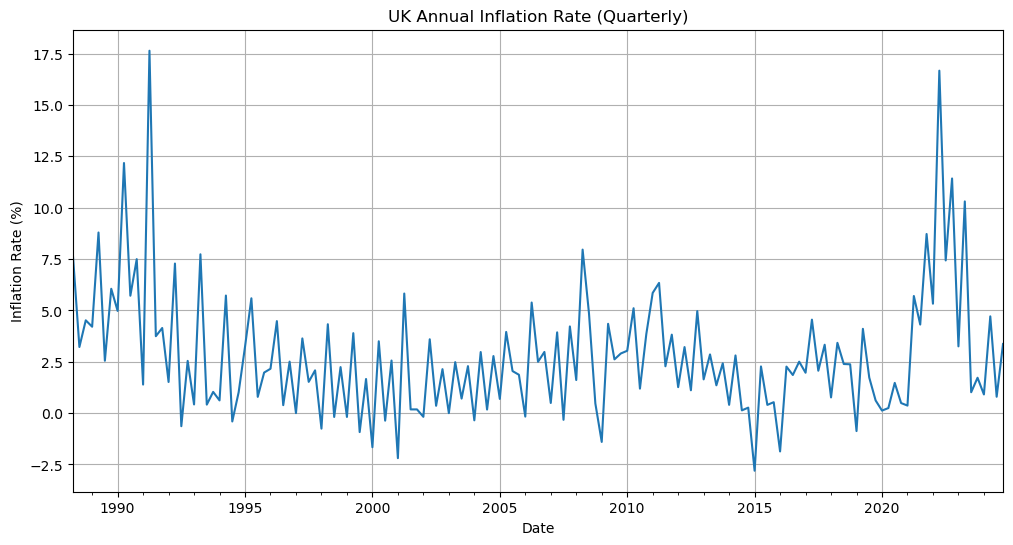

In [28]:
df_inflation = df_cpi_quarterly.dropna()

# Plot
df_inflation['Annual Inflation Rate'].plot(title='UK Annual Inflation Rate (Quarterly)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.show()

In [29]:
# Extract the Annual Inflation Rate series
inflation_rate_series = df_inflation['Annual Inflation Rate']

# Perform the ADF test
adf_result = adfuller(inflation_rate_series)

# Display the results
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

print("Augmented Dickey-Fuller Test Results:")
display(adf_output)

Augmented Dickey-Fuller Test Results:


Test Statistic                  -2.790274
p-value                          0.059676
# of Lags Used                  14.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64

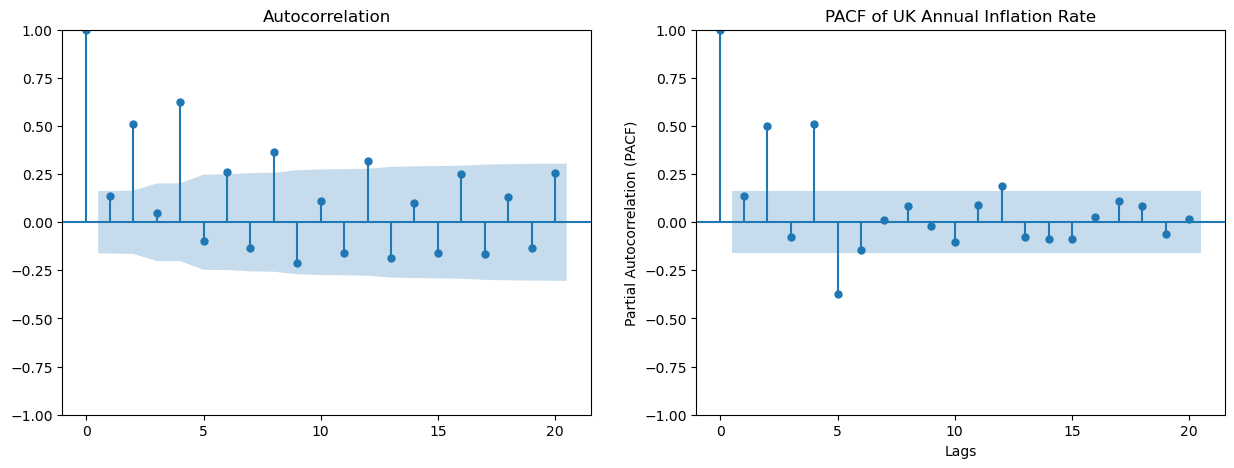

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF for the annual inflation rate
plot_acf(inflation_rate_series, lags=20, ax=axes[0])
# Plot the PACF for the annual inflation rate
plot_pacf(inflation_rate_series, lags=20, ax=axes[1])
plt.title("PACF of UK Annual Inflation Rate")
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation (PACF)')
plt.show()

In [31]:
# Fit an AR(1) model
model_ar1 = AutoReg(df_inflation['Annual Inflation Rate'], lags=1).fit()
print("AR(1) Model Summary:")
display(model_ar1.summary())


p = 6

# Fit an AR(p) model
model_arp = AutoReg(df_inflation['Annual Inflation Rate'], lags=p).fit()
print(f"\nAR({p}) Model Summary:")
display(model_arp.summary())

AR(1) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -371.030
Method:                  Conditional MLE   S.D. of innovations              3.072
Date:                   Sun, 20 Apr 2025   AIC                            748.060
Time:                           11:45:18   BIC                            757.010
Sample:                       09-30-1988   HQIC                           751.696
                            - 12-31-2024                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.3787      0.340      6.988      0.000       1.712       3.046
Annual Inflation Rate.L1     0.1347      0.081      1.656      0.098      -0.025       0.294
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.4238           +0.0000j            7.4238            0.0000
-----------------------------------------------------------------------------
"""


AR(6) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(6)   Log Likelihood                -303.349
Method:                  Conditional MLE   S.D. of innovations              2.080
Date:                   Sun, 20 Apr 2025   AIC                            622.698
Time:                           11:45:18   BIC                            646.288
Sample:                       12-31-1989   HQIC                           632.284
                            - 12-31-2024                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9553      0.303      3.149      0.002       0.361       1.550
Annual Inflation Rate.L1     0.2947      0.083      3.533      0.000       0.131       0.458
Annual Inflation Rate.L2     0.2733      0.082      3.341      0.001       0.113       0.434
Annual Inflation Rate.L3    -0.0534      0.068     -0.782      0.434      -0.187       0.080
Annual Inflation Rate.L4     0.5931      0.068      8.691      0.000       0.459       0.727
Annual Inflation Rate.L5    -0.3314      0.082     -4.056      0.000      -0.492      -0.171
Annual Inflation Rate.L6    -0.1347      0.083     -1.631      0.103      -0.297       0.027
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1875           -0.2851j            1.2212           -0.0375
AR.2            1.1875           +0.2851j            1.2212            0.0375
AR.3           -0.0458           -1.1336j            1.1345           -0.2564
AR.4           -0.0458           +1.1336j            1.1345            0.2564
AR.5           -1.0459           -0.0000j            1.0459           -0.5000
AR.6           -3.6974           -0.0000j            3.6974           -0.5000
-----------------------------------------------------------------------------
"""

In [32]:
def calculate_AR_model(df_inflation, lags):

    # Extract the 'Annual Inflation Rate' column
    inflation_rates = df_inflation['Annual Inflation Rate']

    # Fit the AR model
    model = AutoReg(inflation_rates, lags=lags)
    model_fit = model.fit()
    
    print(model_fit.summary())
    # Manually calculate R-squared
    residuals = model_fit.resid
    ssr = np.sum(residuals**2)
    tss = np.sum((inflation_rates[lags:] - np.mean(inflation_rates[lags:]))**2)
    r_squared = 1 - ssr / tss
    # Print the model summary
    print(f"R-squared: {r_squared:.4f}")
    # Get the AR coefficients (excluding the intercept term)
    ar_coef = model_fit.params[1:]

    # Print AR coefficients
    print("\nAR Coefficients:")
    display(ar_coef)

    # Get the residuals
    residuals = model_fit.resid

    # Plot the ACF of residuals
    plt.figure(figsize=(12, 6))
    plot_acf(residuals, lags=12, alpha=0.05)
    plt.title("Autocorrelation Function (ACF) of Residuals")
    plt.show()

    # Perform the Ljung-Box test on residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test Results for Residuals:")
    display(lb_test)

    # Return results
    return model_fit, ar_coef, lb_test, residuals


In [33]:
results = []
for i in range(1, 13):  # AR models from lag 1 to 12

    model = AutoReg(inflation_rate_series, lags=i)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    results.append([i, aic, bic])
    print(f"AR({i}): AIC={aic:.2f}, BIC={bic:.2f}")

# Find the best models based on AIC and BIC
results_df = pd.DataFrame(results, columns=['Lag', 'AIC', 'BIC'])
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]  # Find row with minimum AIC
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]  # Find row with minimum BIC


print(f"\nBest Model (AIC): Lag {int(best_aic_model['Lag'])}, AIC={best_aic_model['AIC']:.2f}, BIC={best_aic_model['BIC']:.2f}")
print(f"Best Model (BIC): Lag {int(best_bic_model['Lag'])}, AIC={best_bic_model['AIC']:.2f}, BIC={best_bic_model['BIC']:.2f}")

AR(1): AIC=748.06, BIC=757.01
AR(2): AIC=703.38, BIC=715.28
AR(3): AIC=700.63, BIC=715.48
AR(4): AIC=652.76, BIC=670.54
AR(5): AIC=626.82, BIC=647.52
AR(6): AIC=622.70, BIC=646.29
AR(7): AIC=620.78, BIC=647.26
AR(8): AIC=616.83, BIC=646.17
AR(9): AIC=609.03, BIC=641.23
AR(10): AIC=605.87, BIC=640.91
AR(11): AIC=603.69, BIC=641.56
AR(12): AIC=588.92, BIC=629.59

Best Model (AIC): Lag 12, AIC=588.92, BIC=629.59
Best Model (BIC): Lag 12, AIC=588.92, BIC=629.59


In [34]:
test_data = df_inflation.loc[df_inflation.index >= '2022-06-01']
train_data = df_inflation.loc[df_inflation.index < '2022-06-01']

n = 60

predictions = pd.DataFrame(index= train_data.index, columns=range(1, 13))
rmse = {}


for p in range(1, 13):
    
    rmse[p] = 0
    
    for index in range(n, len(train_data)-1):  # Ensure the range covers all valid indices
    
        # Train the model on data up to the current index
        model = AutoReg(train_data['Annual Inflation Rate'][:index+1], lags=p).fit()
        # Predict the next time step (index)
        predictions[p][index+1] = model.predict(start=index+1, end=index+1).values[0]
        
    rmse[p] = np.sqrt(mean_squared_error(train_data['Annual Inflation Rate'][n+1:], predictions[p][n+1:]))

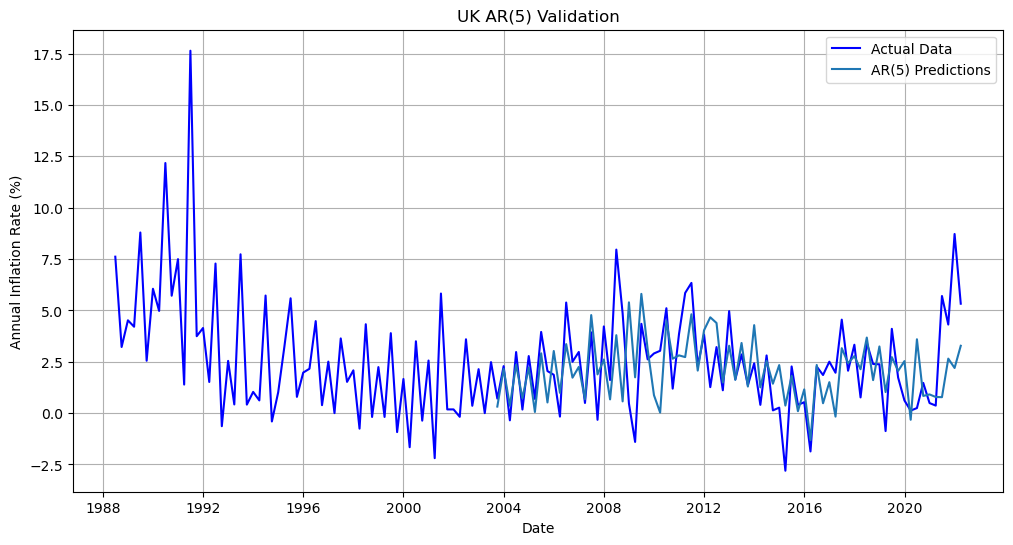

In [35]:
# Plot the predictions for AR(5) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[5], label=f'AR(5) Predictions')
plt.title('UK AR(5) Validation')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

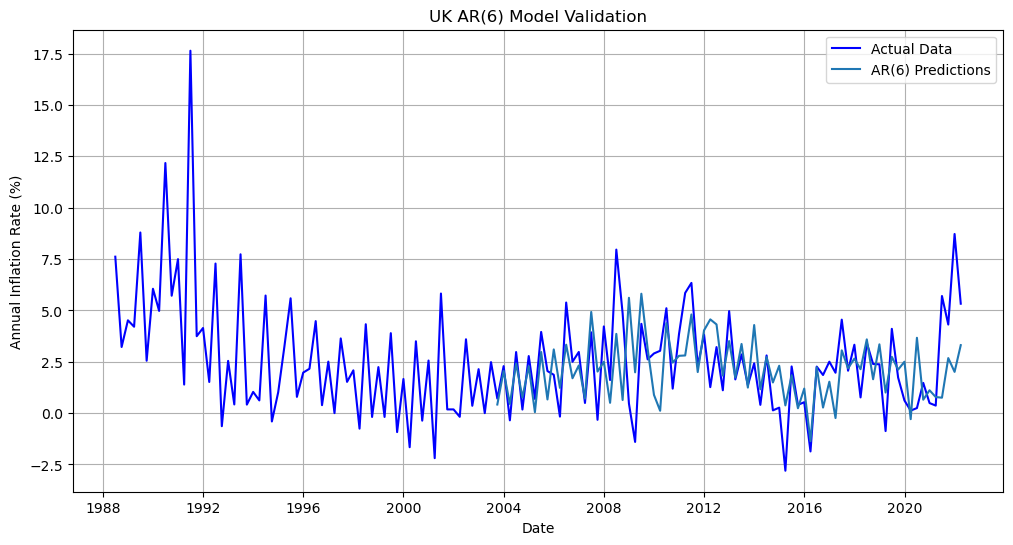

In [36]:
# plot the predictions for AR(6) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[6], label=f'AR(6) Predictions')
plt.title('UK AR(6) Model Validation')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

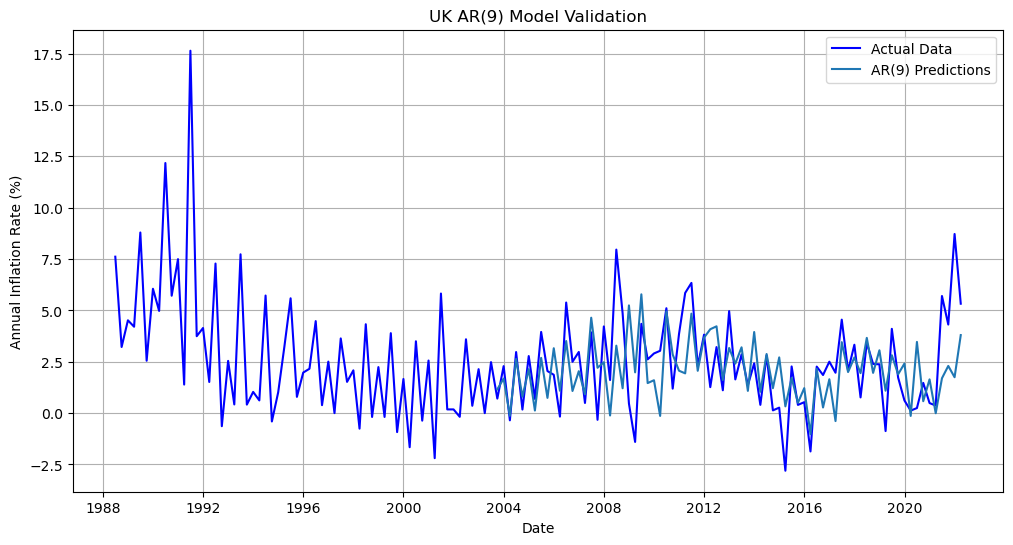

In [37]:
# plot the predictions for AR(9) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[9], label=f'AR(9) Predictions')
plt.title('UK AR(9) Model Validation')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

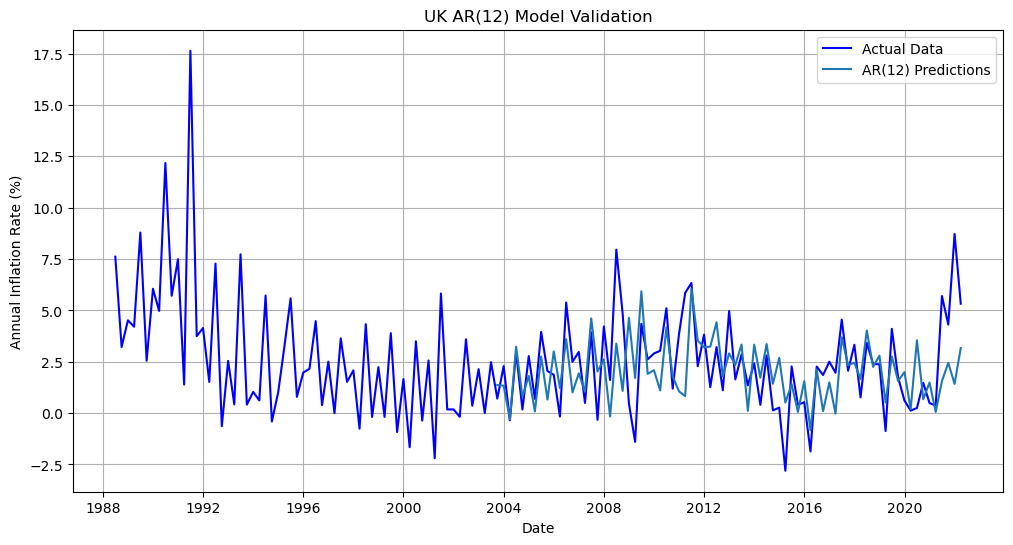

In [38]:
# Plot the predictions for AR(12) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[12], label=f'AR(12) Predictions')
plt.title('UK AR(12) Model Validation')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Print the RMSE values for each model

for p in range(1, 13):
    print(f"AR({p}) RMSE: {rmse[p]:.4f}")

AR(1) RMSE: 2.1690
AR(2) RMSE: 2.0422
AR(3) RMSE: 2.0440
AR(4) RMSE: 2.0157
AR(5) RMSE: 1.8955
AR(6) RMSE: 1.9183
AR(7) RMSE: 1.9651
AR(8) RMSE: 1.9480
AR(9) RMSE: 1.9164
AR(10) RMSE: 1.9505
AR(11) RMSE: 1.9756
AR(12) RMSE: 1.9276


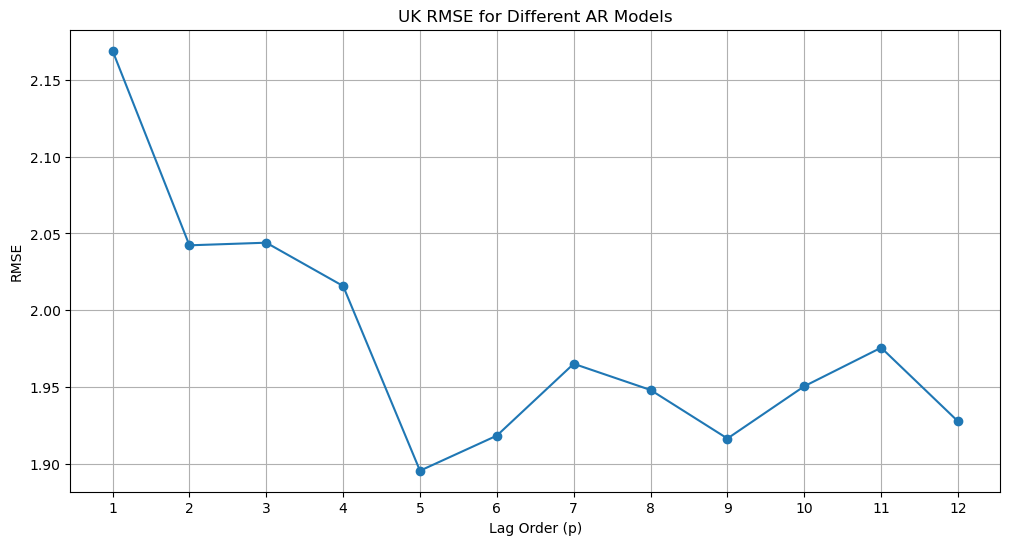

In [40]:
# Plot the RMSE values for each model
plt.figure(figsize=(12, 6))
plt.plot(range(1, 13), list(rmse.values()), marker='o')  # Extract values from the rmse dictionary
plt.title('UK RMSE for Different AR Models')
plt.xlabel('Lag Order (p)')
plt.ylabel('RMSE')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

In [41]:
# Fit ARDL model with exogs
test_data1 = df_inflation.loc[df_inflation.index >= '2022-06-01']
train_data1 = df_inflation.loc[df_inflation.index < '2022-06-01']
test_data = test_data1['Annual Inflation Rate']
train_data = train_data1['Annual Inflation Rate']

exog = df_merged[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']]
train_exog = exog.loc[exog.index < '2022-06-01']
test_exog = exog.loc[exog.index >= '2022-06-01']

# Initialize variables to store the best model
best_aic = np.inf
best_bic = np.inf
best_lag = None
best_order = None

for p in range(1, 13):
    for q in range(1, 13):
        model_ardl = ARDL(train_data, lags=p, exog=train_exog, order = q ).fit()
        
        if model_ardl.aic < best_aic:
            best_aic = model_ardl.aic
            best_order = (p, q)
            best_model = model_ardl
        
        if model_ardl.bic < best_bic:
            best_bic = model_ardl.bic
            best_lag = (p, q)
            best_model_bic = model_ardl

# Print the best ARDL model based on AIC and BIC
print(f"Best ARDL Model (AIC): Lag Order {best_order}, AIC={best_aic:.2f}")
display(best_model.summary())
print(f"Best ARDL Model (BIC): Lag Order {best_lag}, BIC={best_bic:.2f}")
display(best_model_bic.summary())
        
    

Best ARDL Model (AIC): Lag Order (12, 12), AIC=497.21


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARDL Model Results                               
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  136
Model:              ARDL(12, 12, 12, 12)   Log Likelihood                -195.605
Method:                  Conditional MLE   S.D. of innovations              1.172
Date:                   Sun, 20 Apr 2025   AIC                            497.209
Time:                           11:45:37   BIC                            646.684
Sample:                       06-30-1991   HQIC                           557.930
                            - 03-31-2022                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.3474      1.093      0.318      0.752      -1.832       2.527
Annual Inflation Rate.L1            0.1123      0.107      1.051      0.297      -0.101       0.325
Annual Inflation Rate.L2            0.0017      0.111      0.016      0.988      -0.219       0.223
Annual Inflation Rate.L3           -0.0144      0.113     -0.127      0.899      -0.240       0.211
Annual Inflation Rate.L4            0.4040      0.112      3.594      0.001       0.180       0.628
Annual Inflation Rate.L5           -0.1872      0.119     -1.569      0.121      -0.425       0.051
Annual Inflation Rate.L6            0.2102      0.120      1.754      0.084      -0.029       0.449
Annual Inflation Rate.L7           -0.0409      0.121     -0.338      0.736      -0.282       0.200
Annual Inflation Rate.L8           -0.0130      0.118     -0.110      0.913      -0.248       0.222
Annual Inflation Rate.L9           -0.0723      0.104     -0.698      0.487      -0.279       0.134
Annual Inflation Rate.L10          -0.2173      0.107     -2.038      0.045      -0.430      -0.005
Annual Inflation Rate.L11          -0.1095      0.111     -0.990      0.326      -0.330       0.111
Annual Inflation Rate.L12           0.1825      0.108      1.686      0.096      -0.033       0.398
Quarterly GDP Change.L0             0.2131      0.091      2.348      0.022       0.032       0.394
Quarterly GDP Change.L1             0.1984      0.114      1.738      0.086      -0.029       0.426
Quarterly GDP Change.L2             0.1932      0.138      1.404      0.165      -0.081       0.468
Quarterly GDP Change.L3             0.1961      0.141      1.392      0.168      -0.085       0.477
Quarterly GDP Change.L4            -0.0731      0.143     -0.512      0.610      -0.358       0.211
Quarterly GDP Change.L5            -0.2265      0.146     -1.552      0.125      -0.518       0.064
Quarterly GDP Change.L6            -0.4334      0.149     -2.905      0.005      -0.731      -0.136
Quarterly GDP Change.L7            -0.3940      0.162     -2.435      0.017      -0.717      -0.071
Quarterly GDP Change.L8            -0.0938      0.289     -0.325      0.746      -0.670       0.482
Quarterly GDP Change.L9             0.1191      0.283      0.420      0.676      -0.446       0.684
Quarterly GDP Change.L10            0.0714      0.282      0.253      0.801      -0.492       0.634
Quarterly GDP Change.L11            0.3079      0.284      1.085      0.281      -0.258       0.874
Quarterly GDP Change.L12            0.0604      0.284      0.213      0.832      -0.506       0.627
Interest Rate Quarterly.L0          1.1449      0.469      2.443      0.017       0.211       2.079
Interest Rate Quarterly.L1         -1.3953      0.810     -1.722      0.089      -3.010       0.220
Interest Rate Quarterly.L2          0.6213      0.902      0.689      0.493      -1.178       2.420
Interest Rate 

Best ARDL Model (BIC): Lag Order (12, 1), BIC=568.18


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARDL Model Results                               
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  136
Model:                 ARDL(12, 1, 1, 1)   Log Likelihood                -235.889
Method:                  Conditional MLE   S.D. of innovations              1.622
Date:                   Sun, 20 Apr 2025   AIC                            511.777
Time:                           11:45:37   BIC                            568.183
Sample:                       06-30-1991   HQIC                           534.690
                            - 03-31-2022                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.8597      0.674      1.276      0.205      -0.476       2.196
Annual Inflation Rate.L1           0.2401      0.092      2.616      0.010       0.058       0.422
Annual Inflation Rate.L2           0.1506      0.098      1.543      0.126      -0.043       0.344
Annual Inflation Rate.L3           0.0617      0.098      0.628      0.531      -0.133       0.256
Annual Inflation Rate.L4           0.4483      0.094      4.785      0.000       0.263       0.634
Annual Inflation Rate.L5          -0.1745      0.102     -1.716      0.089      -0.376       0.027
Annual Inflation Rate.L6           0.0263      0.103      0.256      0.799      -0.178       0.231
Annual Inflation Rate.L7          -0.0724      0.101     -0.715      0.476      -0.273       0.128
Annual Inflation Rate.L8           0.0931      0.102      0.912      0.364      -0.109       0.296
Annual Inflation Rate.L9          -0.1453      0.094     -1.540      0.127      -0.332       0.042
Annual Inflation Rate.L10         -0.0877      0.096     -0.909      0.365      -0.279       0.104
Annual Inflation Rate.L11          0.0647      0.098      0.662      0.509      -0.129       0.258
Annual Inflation Rate.L12          0.2234      0.098      2.273      0.025       0.029       0.418
Quarterly GDP Change.L0            0.2904      0.087      3.338      0.001       0.118       0.463
Quarterly GDP Change.L1            0.1703      0.096      1.779      0.078      -0.019       0.360
Interest Rate Quarterly.L0         0.6569      0.440      1.492      0.139      -0.216       1.530
Interest Rate Quarterly.L1        -0.6701      0.433     -1.549      0.125      -1.528       0.188
Unemployment Rate Quarterly.L0     1.5361      0.886      1.733      0.086      -0.222       3.294
Unemployment Rate Quarterly.L1    -1.6614      0.854     -1.945      0.054      -3.355       0.032
==================================================================================================
"""

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ardl import ARDL
from sklearn.metrics import mean_squared_error


test_data1 = df_inflation.loc[df_inflation.index >= '2022-06-01']
train_data1 = df_inflation.loc[df_inflation.index < '2022-06-01']
test_data = test_data1['Annual Inflation Rate']
train_data = train_data1['Annual Inflation Rate']
exog = df_merged[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']]
train_exog = exog.loc[exog.index < '2022-06-01']
test_exog = exog.loc[exog.index >= '2022-06-01']


model_ardl = ARDL(train_data, lags=12, exog=train_exog, order=12, causal =True )
result = model_ardl.fit()


# Extract coefficients by position
coefficients = result.params

# 2. Extract Coefficients by Position
n_ar = 12  # Number of AR lags


intercept = coefficients[0]  
ar_coefs = coefficients[1:n_ar+1] 

# Exogenous coefficients 
gdp_lag = coefficients[n_ar+1:n_ar+13]      
interest_lag = coefficients[n_ar+13:n_ar+25]  
unemp_lag = coefficients[n_ar+25:n_ar+37]     

# 3. Manual Forecasting Function
def manual_ardl_forecast(train_endog, test_endog, train_exog, test_exog, 
                        intercept, ar_coefs, gdp_lag, interest_lag, unemp_lag):
    
    combined_endog = pd.concat([train_endog, test_endog])
    combined_exog = pd.concat([train_exog, test_exog])
    predictions = []
    
    for i in range(len(train_endog), len(combined_endog)):
      
        ar_lags = combined_endog.iloc[i-12:i].values[::-1]  # Most recent first
        ar_component = np.dot(ar_coefs, ar_lags)
        

        lagged_exog = combined_exog.iloc[i-12:i].iloc[::-1]
        exog_component = (np.dot(gdp_lag, lagged_exog['Quarterly GDP Change'].values) +
                        np.dot(interest_lag, lagged_exog['Interest Rate Quarterly'].values) +
                        np.dot(unemp_lag, lagged_exog['Unemployment Rate Quarterly'].values))
            
        # Combine all components
        y_hat = intercept + ar_component + exog_component
        predictions.append(y_hat)
    
    return pd.Series(predictions, index=test_endog.index)

# 4. Generate Forecasts
pred_manual = manual_ardl_forecast(
    train_data, test_data, train_exog, test_exog,
    intercept, ar_coefs, gdp_lag, interest_lag, unemp_lag
)



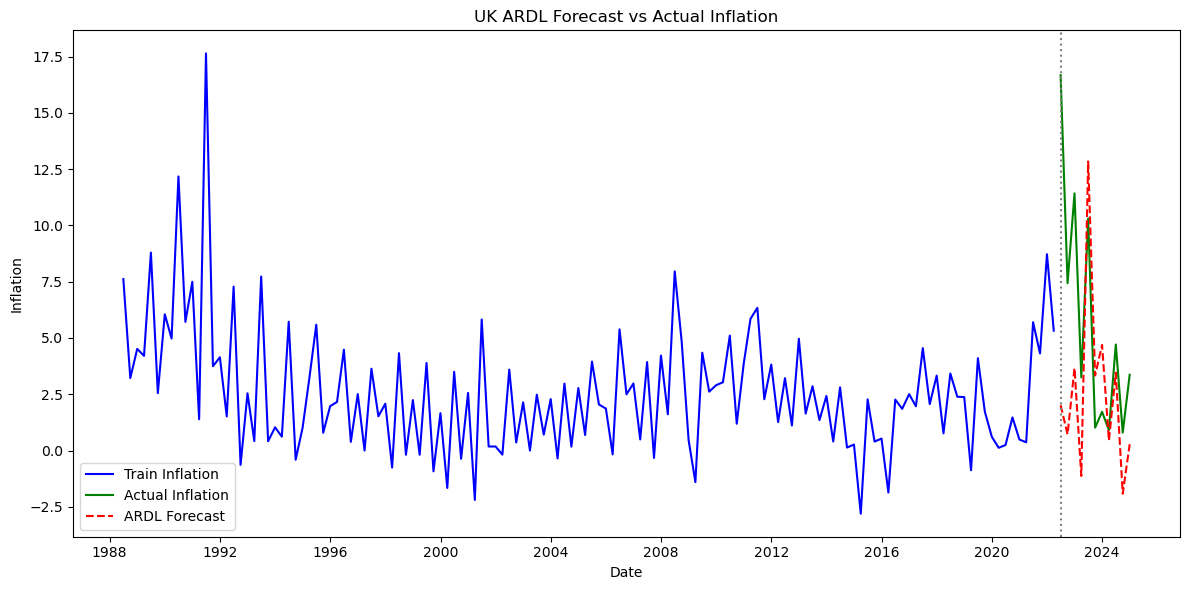

RMSE for ARDL: 5.865351783757745


In [43]:

# Plotting train, test, and forecast data
plt.figure(figsize=(12, 6))

# Plot the train data
plt.plot(train_data, label="Train Inflation", color='blue')

# Plot the test data (actual)
plt.plot(test_data, label="Actual Inflation", color='green')

# Plot the ARDL forecast
plt.plot(pred_manual, label="ARDL Forecast", linestyle='--', color='red')

# Add a vertical line to show the train/test split
plt.axvline(x=test_data.index[0], color='gray', linestyle=':')

# Add titles and labels
plt.title("UK ARDL Forecast vs Actual Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")

# Show the legend
plt.legend()

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print RMSE
rmse = np.sqrt(mean_squared_error(test_data, pred_manual))
print(f"RMSE for ARDL: {rmse}")


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

def ar_forecast(p):

    test_data1 = df_inflation.loc[df_inflation.index >= '2022-06-01']
    train_data1 = df_inflation.loc[df_inflation.index < '2022-06-01']
    
    test_data = test_data1['Annual Inflation Rate']
    train_data = train_data1['Annual Inflation Rate']
    
    # Fit AR(p) on train_data only
    model_ar = AutoReg(train_data, lags=p).fit()
    coef = model_ar.params  # Intercept + coefficients

    # Combine full data for manual forecasting
    combined_data = pd.concat([train_data, test_data]).copy()

    # Manual prediction loop using actual values
    pred_ar = []

    for i in range(len(train_data), len(combined_data)):
        lags_values = combined_data.iloc[i-p:i].values[::-1]  # lagged actual values, reversed
        y_hat = coef[0] + np.dot(coef[1:], lags_values)  # Intercept + lag coefficients
        pred_ar.append(y_hat)

    # Store as a Series
    pred_ar = pd.Series(pred_ar, index=test_data.index)

    # Plot forecast vs actual for AR(p) model
    plt.figure(figsize=(12, 6))

    # Plot the train data
    plt.plot(train_data, label="Train Inflation", color='blue')

    # Plot the test data (actual)
    plt.plot(test_data, label="Actual Inflation", color='green')

    # Plot the AR(p) forecast
    plt.plot(pred_ar, label=f" UK AR({p}) Forecast", linestyle='--', color='red')

    # Add a vertical line to show the train/test split
    plt.axvline(x=test_data.index[0], color='gray', linestyle=':')

    # Add titles and labels
    plt.title(f"UK AR({p}) Forecast vs Actual Inflation")
    plt.xlabel("Date")
    plt.ylabel("Inflation")

    # Show the legend
    plt.legend()

    # Adjust layout for better display
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_data, pred_ar))
    print(f"RMSE for AR({p}): {rmse}")
    
    return pred_ar, coef, rmse



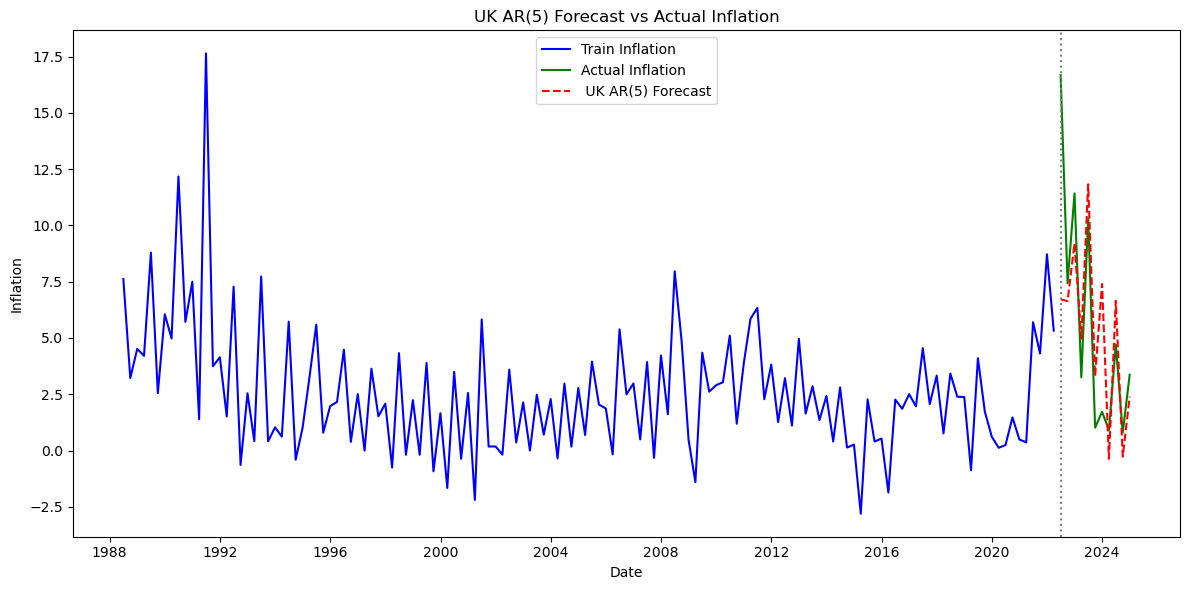

RMSE for AR(5): 3.7502791507994337


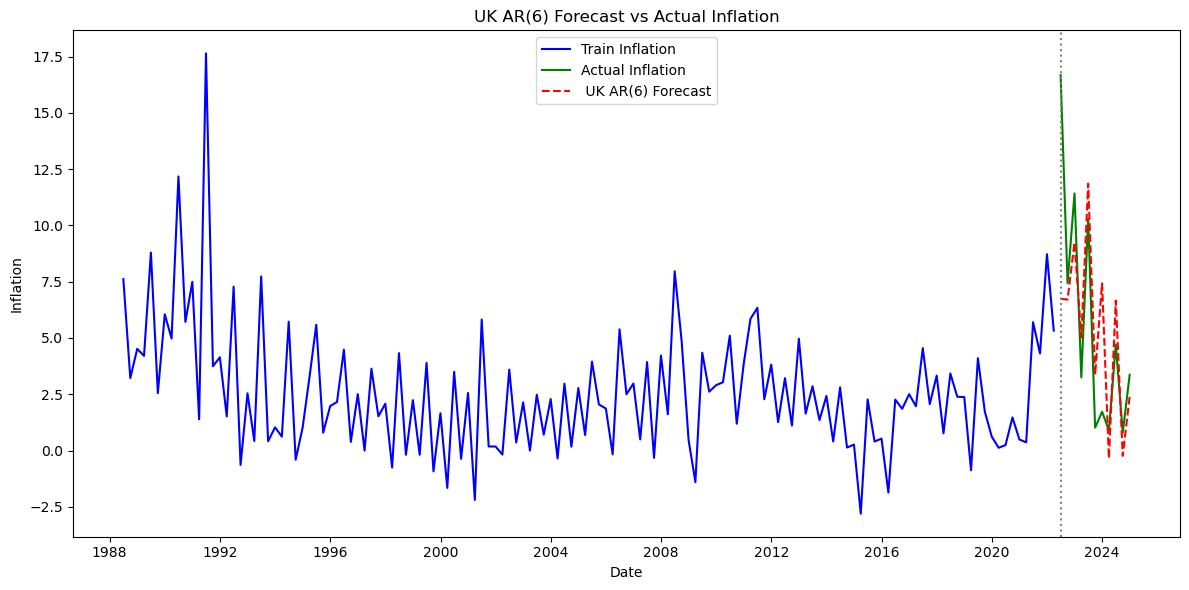

RMSE for AR(6): 3.752586443972519


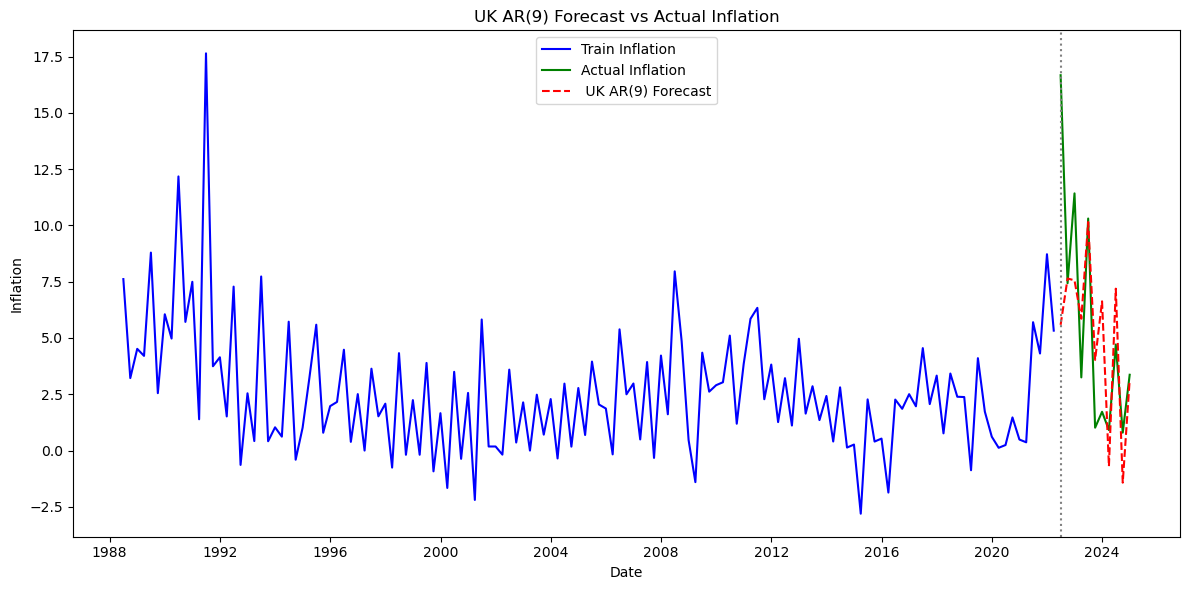

RMSE for AR(9): 4.172262367779204


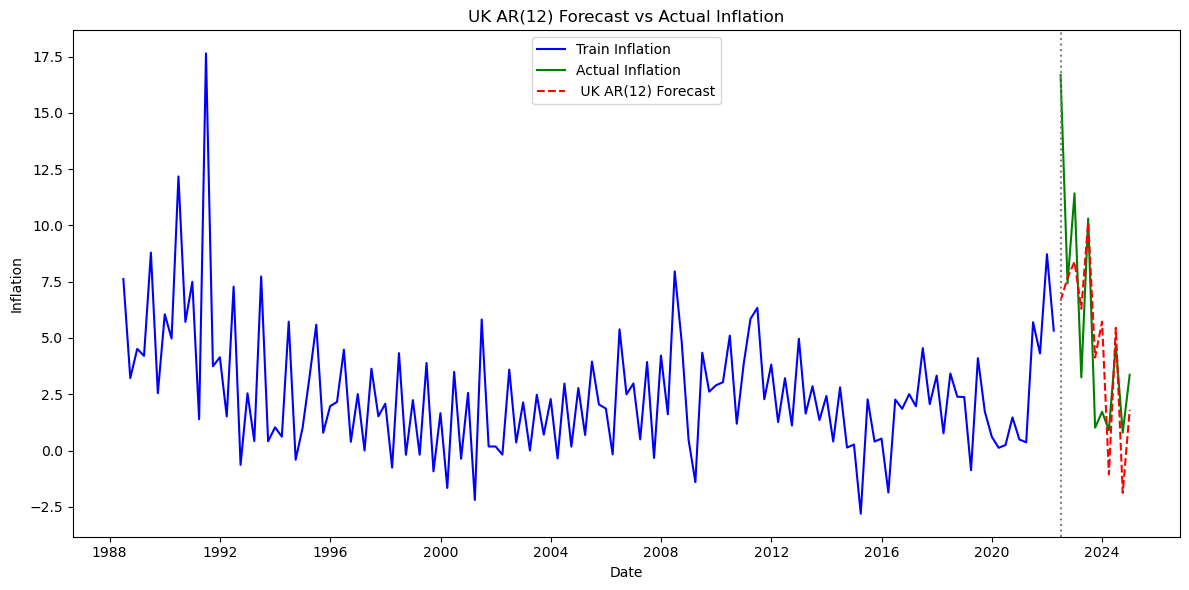

RMSE for AR(12): 3.796620106303223


In [45]:
pred1, coef1, rmse1= ar_forecast(5)
pred2, coef2, rmse2= ar_forecast(6)
pred3, coef3, rmse3= ar_forecast(9)
pred5, coef5, rmse5= ar_forecast(12)


Predictions for the next 4 points: 2025-03-31    1.796454
2025-06-30    4.403606
2025-09-30    1.207810
2025-12-31    3.636753
Freq: QE-DEC, dtype: float64


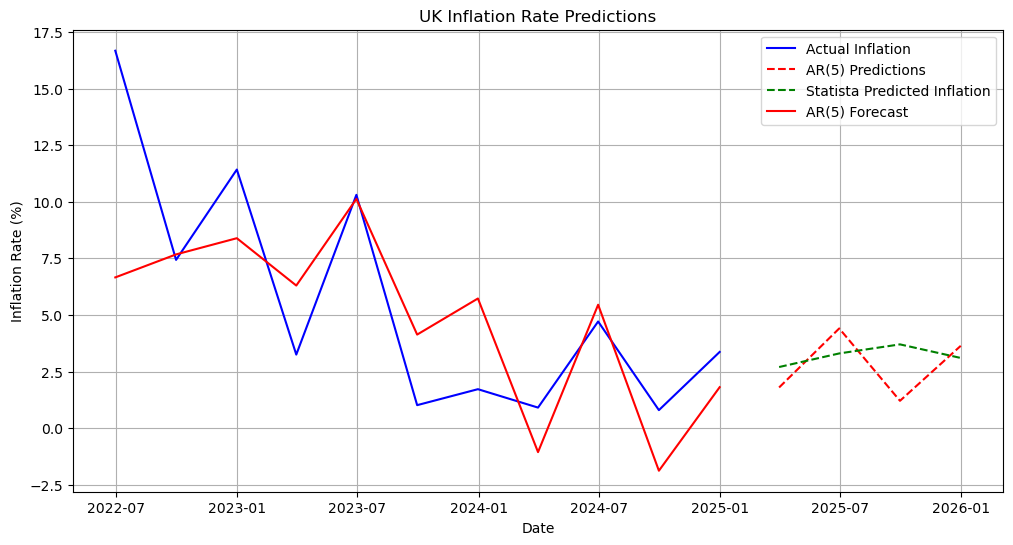

In [46]:
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model to the data
model_ar5 = AutoReg(df_inflation['Annual Inflation Rate'], lags=5).fit()

# Predict the next 4 points
predictions1year = model_ar5.forecast(steps=4)

# Print the predicted values
print(f"Predictions for the next 4 points: {predictions1year}")

predicted = pd.DataFrame(predictions1year, index=pd.date_range(start='2025-03-30', periods=4, freq='Q'), columns=['Predicted Inflation'])


# Convert predicted_fred_arr to a numeric type
predicted_statista_arr = np.array([2.7, 3.3, 3.7, 3.1])  # Ensure the values are floats

# Create the DataFrame
predicted_statista = pd.DataFrame(predicted_statista_arr, index=pd.date_range(start='2025-03-30', periods=4, freq='Q'), columns=['Statista_Predicted Inflation'])

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data1['Annual Inflation Rate'], label='Actual Inflation', color='blue')
plt.plot(predicted, label='AR(5) Predictions', linestyle='--', color='red')
plt.plot(predicted_statista, label='Statista Predicted Inflation', linestyle='--', color='green')
plt.plot(pred5, label=f"AR(5) Forecast", color='red')
plt.title('UK Inflation Rate Predictions')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  136
Model:                        AutoReg(5)   Log Likelihood                -271.083
Method:                  Conditional MLE   S.D. of innovations              1.916
Date:                   Sun, 20 Apr 2025   AIC                            556.167
Time:                           11:45:42   BIC                            576.293
Sample:                       09-30-1989   HQIC                           564.345
                            - 03-31-2022                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.7266      0.304      2.392      0.017       0.131       1.322
Annual Inflation Rate.L1     0.2660      0.084      3.156      0.

Annual Inflation Rate.L1    0.266029
Annual Inflation Rate.L2    0.154203
Annual Inflation Rate.L3   -0.045077
Annual Inflation Rate.L4    0.619634
Annual Inflation Rate.L5   -0.285083
dtype: float64

<Figure size 1200x600 with 0 Axes>

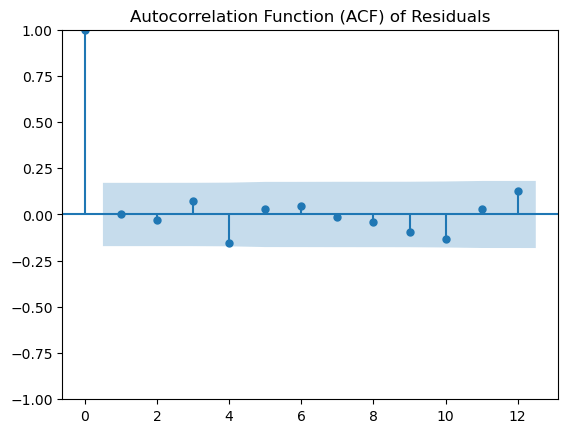

Ljung-Box Test Results for Residuals:


,lb_stat,lb_pvalue
10,8.573753,0.572976


In [47]:
train_data = df_inflation.loc[df_inflation.index < '2022-06-01']

model_fit5, ar_coef5, lb_test5, residuals5 = calculate_AR_model(train_data, lags=5)

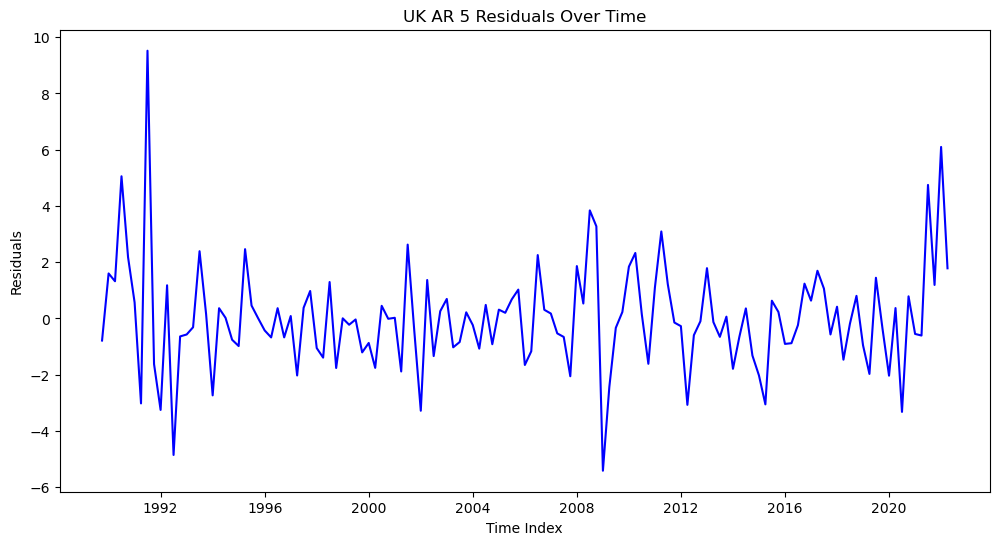

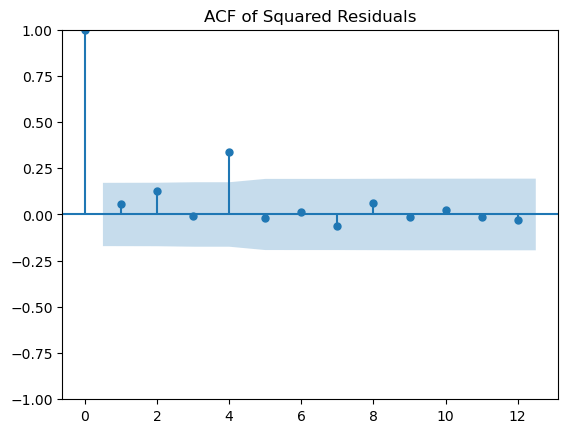

ARCH Test Results:
LM Statistic      31.121574
p-value            0.000560
F-statistic        3.808893
F-test p-value     0.000195
dtype: float64


In [48]:
# Plot the residuals to visually inspect for volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(residuals5, color='blue')
plt.title('UK AR 5 Residuals Over Time')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.show()

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(residuals5 ** 2, lags=12, alpha = 0.05)
plt.title('ACF of Squared Residuals')
plt.show()

# Perform the ARCH-LM Test
arch_test = het_arch(residuals5)
arch_test_results = pd.Series(arch_test, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results)


In [49]:
!pip install quantecon  #toinstall remove#

ERROR: Invalid requirement: '#toinstall'


In [50]:
#!pip install quantecon  #toinstall remove#

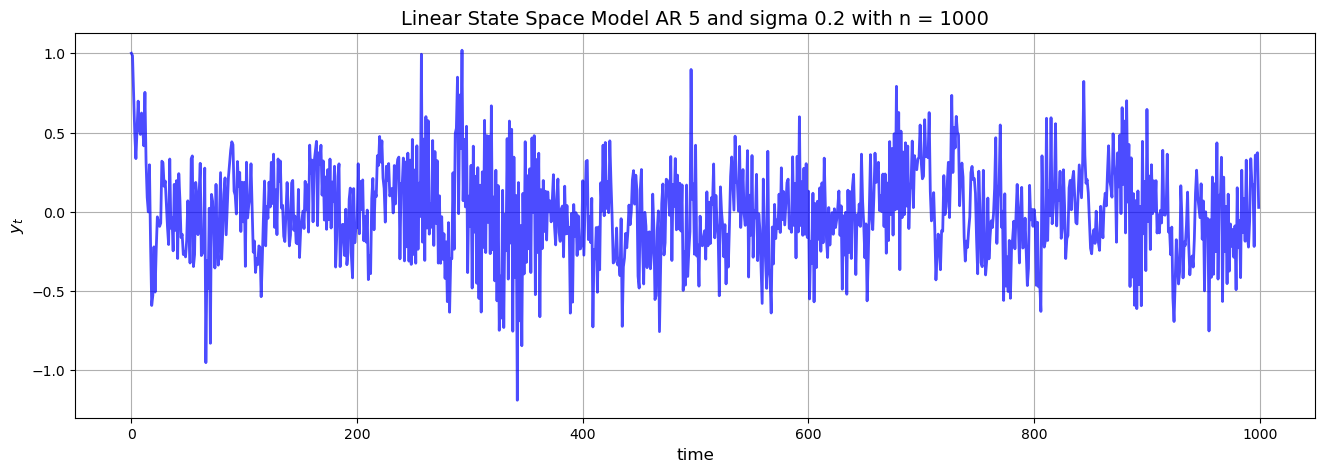

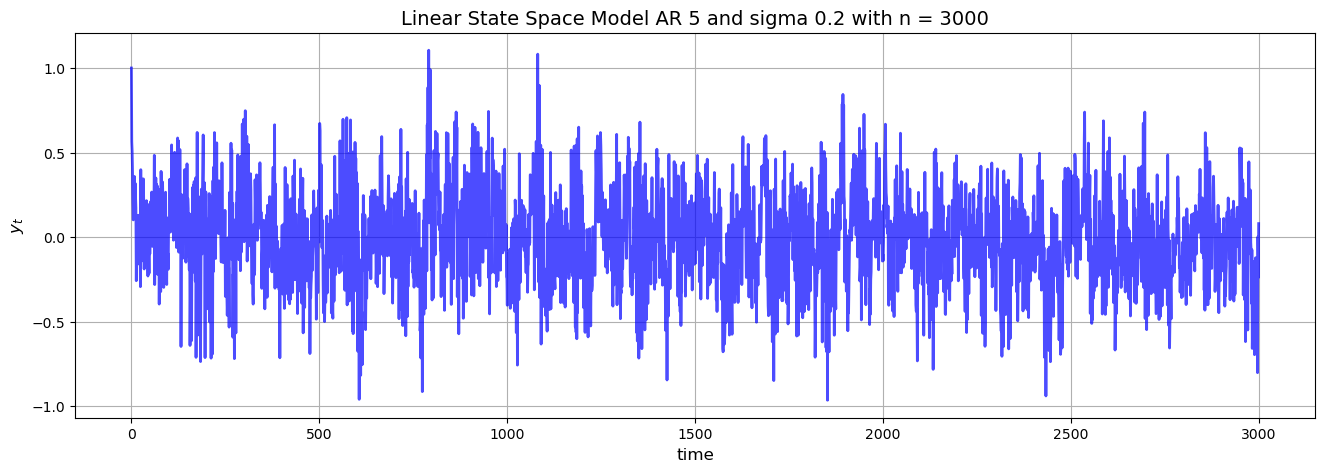

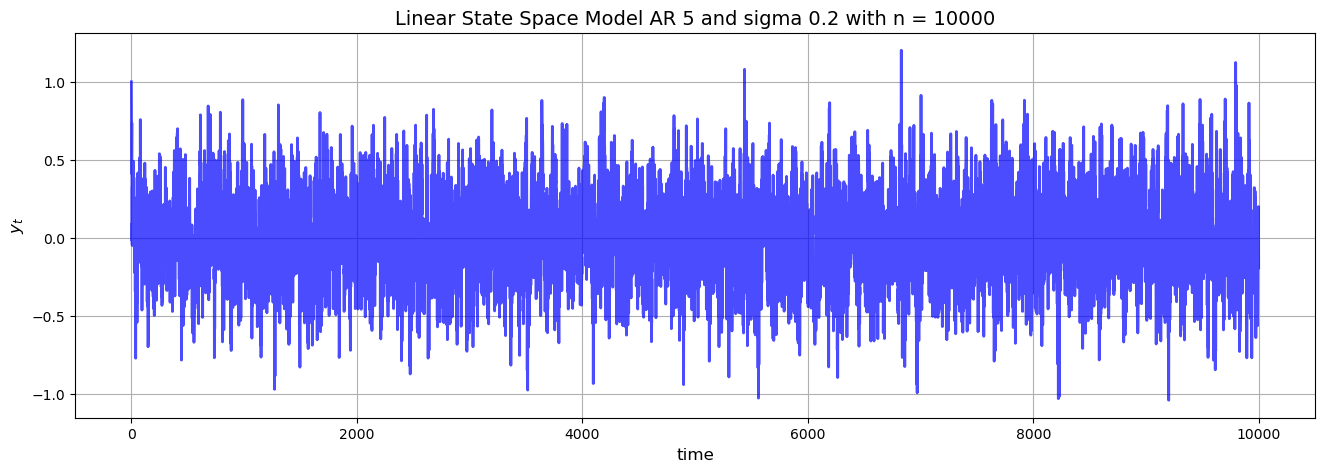

In [51]:

from quantecon import LinearStateSpace


import numpy as np
import matplotlib.pyplot as plt

# 4. Define a wrapper function.

def plot_lss(A, C, G, n, ts_length):
    ar = LinearStateSpace(A, C, G, mu_0=np.ones(n))  
    x, y = ar.simulate(ts_length, random_state=None)  

    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    y = y.flatten()
    ax.plot(y, 'b-', lw=2, alpha=0.7)
    ax.grid()
    ax.set_xlabel('time', fontsize=12)
    ax.set_ylabel('$y_t$', fontsize=12)
    ax.set_title(f'Linear State Space Model AR 5 and sigma 0.2 with n = {ts_length}', fontsize=14)
    plt.show()


phi_1, phi_2, phi_3, phi_4, phi_5, sigma = 0.3435, 0.1941, -0.046129, 0.567491, -0.380588, 0.2

A1 = [[phi_1, phi_2, phi_3, phi_4, phi_5],
      [1,     0,     0,     0 , 0   ],
      [0,     1,     0,     0, 0    ],
      [0,     0,     1,     0, 0    ],
      [0,     0,     0,     1, 0    ],
      ]

C1 = [[sigma],[0],[0],[0], [0]]


G1 = [1, 0, 0, 0, 0]

plot_lss(A1, C1, G1, n=5, ts_length = 1000)
plot_lss(A1, C1, G1, n=5, ts_length = 3000)
plot_lss(A1, C1, G1, n=5, ts_length = 10000)


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 50, 'subsample': 0.6}
Validation RMSE (static): 2.1762
Test RMSE (static): 5.3582
Validation Rolling RMSE: 1.8928
Test Rolling RMSE: 4.3233

5-Step-Ahead Forecast with Static Predictions:
2025-03-31    6.752892
2025-06-30    2.234993
2025-09-30    6.156847
2025-12-31    1.917606
2026-03-31    4.808136
Freq: QE-DEC, dtype: float32


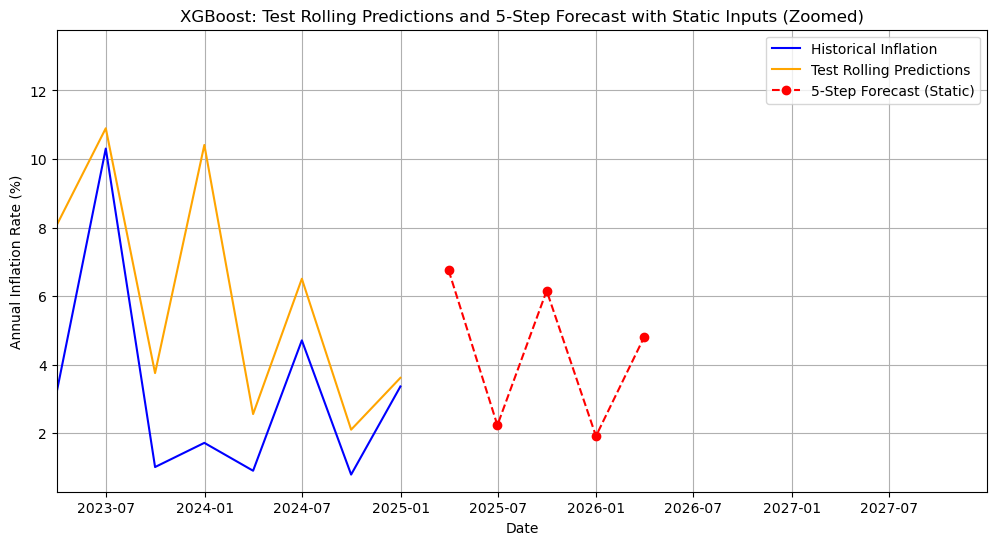

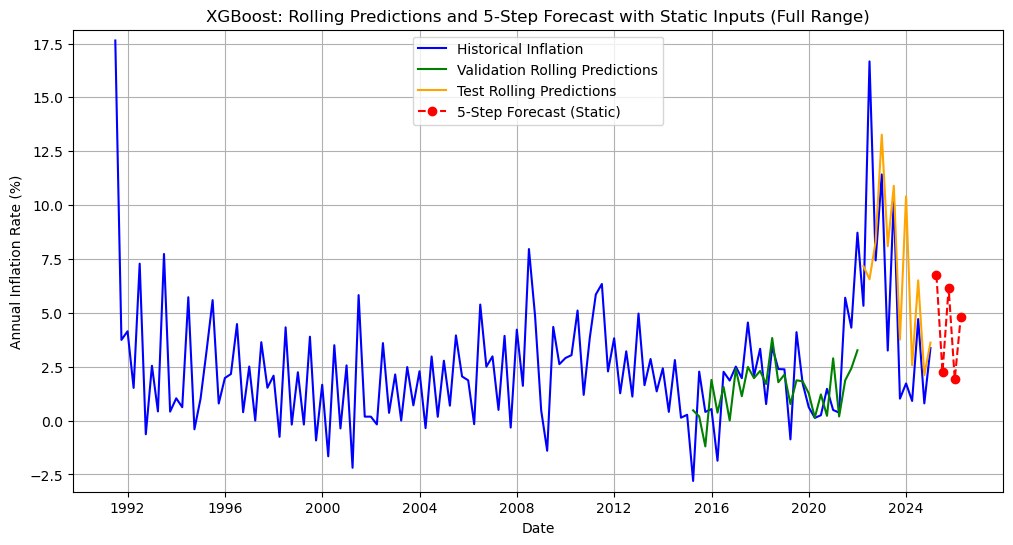

In [52]:
%pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Lagged features
lags = 12
df_lagged = df_merged.copy()
for lag in range(1, lags + 1):
    df_lagged[f'Annual Inflation Rate_lag{lag}'] = df_lagged['Annual Inflation Rate'].shift(lag)

# Feature Engineering
df_lagged['GDP_Interest_Interaction'] = df_lagged['Quarterly GDP Change'] * df_lagged['Interest Rate Quarterly']
df_lagged['GDP_Unemployment_Interaction'] = df_lagged['Quarterly GDP Change'] * df_lagged['Unemployment Rate Quarterly']
df_lagged['Interest_Unemployment_Interaction'] = df_lagged['Interest Rate Quarterly'] * df_lagged['Unemployment Rate Quarterly']
df_lagged['Inflation_Volatility'] = df_lagged['Annual Inflation Rate'].rolling(window=4).std()
df_lagged['Recession_2008'] = (df_lagged.index.year.isin([2008, 2009])).astype(int)
df_lagged['COVID_2020'] = (df_lagged.index.year >= 2020).astype(int)
df_lagged['Trend'] = np.arange(len(df_lagged))

# Drop rows with NaN values
df_lagged = df_lagged.dropna()

# Features
exog_cols = ['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']
additional_features = [
    'GDP_Interest_Interaction',
    'GDP_Unemployment_Interaction',
    'Interest_Unemployment_Interaction',
    'Inflation_Volatility',
    'Recession_2008',
    'COVID_2020',
    'Trend'
]
feature_cols = [f'Annual Inflation Rate_lag{i}' for i in range(1, lags + 1)] + exog_cols + additional_features

# Train-test-val split
train_end = '2015-03-31'
val_end = '2022-03-31'
train_data_xgb = df_lagged[df_lagged.index < train_end]
val_data_xgb = df_lagged[(df_lagged.index >= train_end) & (df_lagged.index < val_end)]
test_data_xgb = df_lagged[df_lagged.index >= val_end]

X_train = train_data_xgb[feature_cols]
y_train = train_data_xgb['Annual Inflation Rate']
X_val = val_data_xgb[feature_cols]
y_val = val_data_xgb['Annual Inflation Rate']
X_test = test_data_xgb[feature_cols]
y_test = test_data_xgb['Annual Inflation Rate']

# XGBoost model with hyperparameter tuning
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=tscv,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model_xgb = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Validation set evaluation
y_pred_val = best_model_xgb.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
print(f"Validation RMSE (static): {rmse_val:.4f}")

# Test set evaluation
y_pred_test = best_model_xgb.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
print(f"Test RMSE (static): {rmse_test:.4f}")

# Rolling predictions for validation and test periods
rolling_predictions_xgb = pd.Series(index=df_lagged.index, dtype=float)
rolling_window = 50

for i in range(rolling_window, len(df_lagged)):
    train_data = df_lagged.iloc[:i]
    test_data = df_lagged.iloc[i:i+1]
    X_train_roll = train_data[feature_cols]
    y_train_roll = train_data['Annual Inflation Rate']
    X_test_roll = test_data[feature_cols]
    model = xgb.XGBRegressor(objective='reg:squarederror', **grid_search.best_params_)
    model.fit(X_train_roll, y_train_roll)
    pred = model.predict(X_test_roll)
    rolling_predictions_xgb.iloc[i] = pred[0]

# Split rolling predictions into validation and test
val_rolling_pred = rolling_predictions_xgb.loc[val_data_xgb.index]
test_rolling_pred = rolling_predictions_xgb.loc[test_data_xgb.index]

# Compute RMSE for rolling predictions
rmse_rolling_val = np.sqrt(mean_squared_error(y_val, val_rolling_pred))
rmse_rolling_test = np.sqrt(mean_squared_error(y_test, test_rolling_pred))
print(f"Validation Rolling RMSE: {rmse_rolling_val:.4f}")
print(f"Test Rolling RMSE: {rmse_rolling_test:.4f}")

# Recursive forecasting with static predictions
def xgb_recursive_forecast_with_static(model, last_data, feature_cols, steps=5, static_preds=None, static_index=None):
    if isinstance(last_data, pd.DataFrame):
        last_data = last_data.iloc[-1]
    current_features = last_data[feature_cols].copy()
    last_date = last_data.name
    future_dates = pd.date_range(start=last_date, periods=steps+1, freq='Q')[1:]
    predictions = []

    # Convert static predictions to a Series if provided
    static_preds_series = None
    if static_preds is not None and static_index is not None:
        static_preds_series = pd.Series(static_preds, index=static_index)

    for step in range(steps):
        # Predict using current features
        pred = model.predict(current_features.values.reshape(1, -1))[0]
        predictions.append(pred)

        # Update lagged features
        for lag in range(lags, 1, -1):
            current_features[f'Annual Inflation Rate_lag{lag}'] = \
                current_features[f'Annual Inflation Rate_lag{lag-1}']

        # Use static predictions for lag1 if available and within static index
        if static_preds_series is not None and step < len(static_preds_series):
            current_features['Annual Inflation Rate_lag1'] = static_preds_series.iloc[step]
        else:
            current_features['Annual Inflation Rate_lag1'] = pred

        # Update trend feature
        if 'Trend' in current_features:
            current_features['Trend'] += 1

    return pd.Series(predictions, index=future_dates)

# Apply static-based forecasting
last_data_point = df_lagged.iloc[-1]
static_predictions = y_pred_test  # Static predictions from test set
static_index = test_data_xgb.index  # Index of test set

forecast_5_steps_static = xgb_recursive_forecast_with_static(
    best_model_xgb,
    last_data_point,
    feature_cols,
    steps=5,
    static_preds=static_predictions,
    static_index=static_index
)
print("\n5-Step-Ahead Forecast with Static Predictions:")
print(forecast_5_steps_static)

# Plot 1: Zoomed-in plot with static-based forecast
plt.figure(figsize=(12, 6))
plt.plot(df_lagged.index, df_lagged['Annual Inflation Rate'], label='Historical Inflation', color='blue')
plt.plot(test_rolling_pred.index, test_rolling_pred, label='Test Rolling Predictions', color='orange', linestyle='-')
plt.plot(forecast_5_steps_static.index, forecast_5_steps_static, label='5-Step Forecast (Static)', color='red', linestyle='--', marker='o')
plt.xlim(pd.to_datetime('2023-03-31'), pd.to_datetime('2027-12-31'))
visible_data = pd.concat([
    df_lagged['Annual Inflation Rate'].loc[df_lagged.index >= '2023-03-31'],
    test_rolling_pred,
    forecast_5_steps_static
])
y_min = visible_data.min() - 0.5
y_max = visible_data.max() + 0.5
plt.ylim(y_min, y_max)
plt.title('XGBoost: Test Rolling Predictions and 5-Step Forecast with Static Inputs (Zoomed)')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Full range plot with static-based forecast
plt.figure(figsize=(12, 6))
plt.plot(df_lagged.index, df_lagged['Annual Inflation Rate'], label='Historical Inflation', color='blue')
plt.plot(val_rolling_pred.index, val_rolling_pred, label='Validation Rolling Predictions', color='green', linestyle='-')
plt.plot(test_rolling_pred.index, test_rolling_pred, label='Test Rolling Predictions', color='orange', linestyle='-')
plt.plot(forecast_5_steps_static.index, forecast_5_steps_static, label='5-Step Forecast (Static)', color='red', linestyle='--', marker='o')
visible_data_full = pd.concat([
    df_lagged['Annual Inflation Rate'],
    val_rolling_pred,
    test_rolling_pred,
    forecast_5_steps_static
])
y_min_full = visible_data_full.min() - 0.5
y_max_full = visible_data_full.max() + 0.5
plt.ylim(y_min_full, y_max_full)
plt.title('XGBoost: Rolling Predictions and 5-Step Forecast with Static Inputs (Full Range)')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

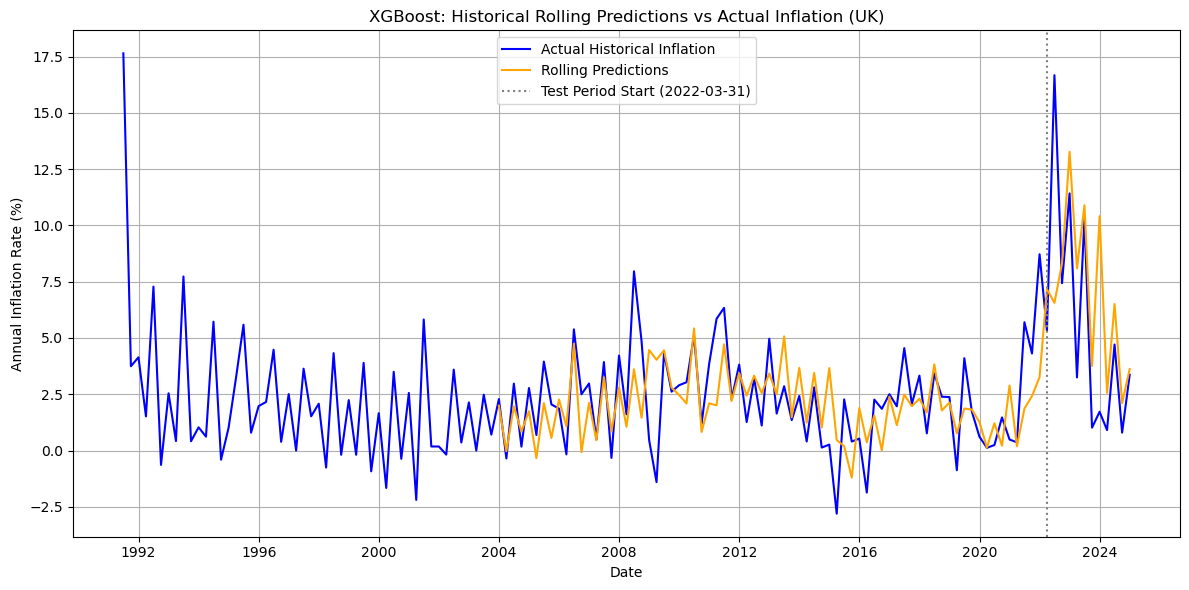

In [53]:
# Plot full historical rolling predictions vs actual historical inflation
plt.figure(figsize=(12, 6))
plt.plot(df_lagged.index, df_lagged['Annual Inflation Rate'], label='Actual Historical Inflation', color='blue')
plt.plot(rolling_predictions_xgb.index, rolling_predictions_xgb, label='Rolling Predictions', color='orange', linestyle='-')
plt.axvline(x=pd.to_datetime('2022-03-31'), color='gray', linestyle=':', label='Test Period Start (2022-03-31)')
plt.title('XGBoost: Historical Rolling Predictions vs Actual Inflation (UK)')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()